In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx

from shapely.geometry import (
    LineString,
    Point,
)
from shapely import (
    union_all,
    ops,
)

import os
import warnings
import itertools

from typing import (
    List,
    Dict,
    Union,
    Iterable,
    Tuple,
    Any,
)

from collections.abc import (
    Collection,
)

In [2]:
# MERIT-Basins path
mb_path = '/project/rrg-mclark/data/geospatial-data/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/'

# cat layer
cat = gpd.read_file(os.path.join(mb_path, 'pfaf_level_02', 'cat_pfaf_72_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'))

# riv layer
riv = gpd.read_file(os.path.join(mb_path, 'pfaf_level_02', 'riv_pfaf_72_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'))

# cst layer
cst = gpd.read_file(os.path.join(mb_path, 'coastal_hillslopes', 'hillslope_72_clean.shp'))

In [3]:
def aggregate_seg(
    rg: nx.DiGraph,
    node: Union[str, int],
    columns: Dict[str, str],
    criteria: str,
    *args,
    **kwargs,
) -> None:
    ...
    
columns = {
    'length': 'lengthkm',
    'area': 'unitarea'
}

criteria = 'length'

In [4]:
rg = nx.from_pandas_edgelist(df=riv,
                             source='COMID',
                             target='NextDownID',
                             edge_attr=riv.columns.to_list(),
                             create_using=nx.DiGraph)

____

Try to write a function that aggregates the geometry of two river segments (by doing so, you are assuming the candidate for aggregation is already known):

In [5]:
segment = riv.loc[riv.COMID.isin([72051873])].geometry.iloc[0]

In [6]:
predecessor = riv.loc[riv.COMID.isin([72053625])].geometry.iloc[0]

In [7]:
def _intersection_based_order(
    l: List,
    element: Any,
    placement: str,
) -> List:
    """
    Returns a list as-is or reversed, depending on `placement` criterion.
    
    Parameters
    ----------
    l: List
        list of items
    element: Any, dependant on `l`
        element present in the list
    placement: str, 'first' or 'last'
        placement of the `element` in `l`
        
    Returns
    -------
    List
        returning `l` as-is or reversed as a List object
        
    Notes
    -----
    The function needs to optimized for future versions
    """
    # check if the element is in the list
    if element not in l:
        raise ValueError(f"{element} is not in `l`")
    
    # check position of `element` in `l`
    if placement == 'first':
        # if the `placement` is 'first', and the element is at the first
        # position, return the list
        if l.index(element) == 0:
            return l.copy()
        else:
            return l.copy()[::-1]
    elif placement == 'last':
        # If the `placement` is 'last', and the element is in the last
        # position, return the list
        if l.index(element) == len(l) - 1:
            return l.copy()
        else:
            return l.copy()[::-1]
    else:
        raise ValueError(f"Cannot interpret LineString {predecessor}")
        
def _intersect_linestring_coords(
    *args: LineString,
) -> List[Tuple[float, float]]:
    """Return a list of coordinates (pairs of floats in tuples) of
    intersected points of various LineStrings
    
    Parameters
    ----------
    args: List-like of shapely.geometry.LineString objects
        LineString object for which the intersection coordinate
        point(s) are desired
        
    Return
    List[Tuple[float, float]]
        A list of coordinate values (pairs of floats in tuples)
    """
    # check dtype of args
    for item in args:
        if not isinstance(item, LineString):
            raise TypeError("all arguments must be of type "
                            "shapely.geometry.LineString")
    # create a list of all input LineString object through *args
    pairs = list(itertools.combinations(args, 2))
    
    # intersection list
    intx_list = []
    
    # go over the pairs and calculate the intersections
    for item in pairs:
        intx = set(item[0].coords).intersection(set(item[1].coords))
        intx_list.append(list(intx)[0])
        
    return intx_list

def _aggregate_linstring_geoms(
    successor: LineString,
    predecessor: LineString,
) -> LineString:
    """Aggregated (Multi-)LineString geometries for `successor` and
    `predecessor` objects
    
    Parameters
    ----------
    successor: shapely.geometry.LineString
        sucessor LineString to be aggregated
    predecessor: shapely.geometry.LineString
        predecessor LineString to be aggregated with `successor`
    
    Returns
    -------
    shapely.LineString:
        aggregated LineString geometry
    """
    # check if successor and predecessor are shapely.geometry.LineString types
    if not isinstance(successor, LineString):
        raise TypeError("`successor` must be of type shapely.geometry.LineString")
    if not isinstance(predecessor, LineString):
        raise TypeError("`predecessor` must be of type shapely.geometry.LineString")
    
    # find the intersection point of both objects
    intx = _intersect_linestring_coords(successor, predecessor)
    # since a list is returned, extract the first element
    intx_point = intx[0]
    
    # re-ordering coordinate points of LineString objects
    successor_ordered = _intersection_based_order(
        list(successor.coords),
        intx_point,
        'first')
    predecessor_ordered = _intersection_based_order(
        list(predecessor.coords),
        intx_point,
        'last')
    
    # merging LineString objects
    aggregated_coords = predecessor_ordered + successor_ordered[1:]
    
    # create a LineString out of the new `aggregated_coords` object
    merged_ls = LineString(aggregated_coords)
    
    return merged_ls

In [8]:
new_segment = _aggregate_linstring_geoms(
    successor=segment,
    predecessor=predecessor
)

In [9]:
print(new_segment)

LINESTRING (-81.94500000000001 44.27750000000002, -81.94416666666667 44.27833333333335, -81.94333333333334 44.27916666666668, -81.94250000000001 44.280000000000015, -81.94250000000001 44.28083333333335, -81.94166666666668 44.28166666666668, -81.94083333333334 44.28250000000001, -81.94000000000001 44.283333333333346, -81.93916666666668 44.28416666666668, -81.93916666666668 44.28500000000001, -81.93833333333335 44.28583333333335, -81.93750000000001 44.28666666666668, -81.93666666666668 44.287500000000016)


<Axes: >

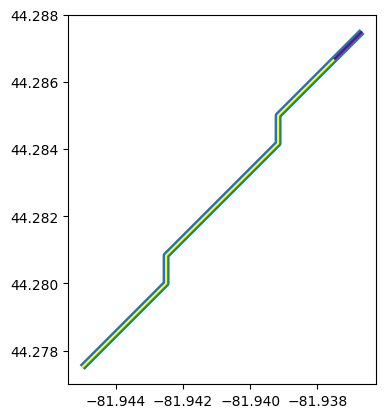

In [10]:
ax = gpd.GeoDataFrame(geometry=[new_segment]).plot(zorder=1, linewidths=5)

gpd.GeoDataFrame(geometry=[segment]).plot(zorder=2, color='purple', ax=ax)
gpd.GeoDataFrame(geometry=[predecessor]).plot(zorder=2, color='yellow', ax=ax)

____

As a substitute for all the codes above, one can use ``shapely.union_all(...)`` function:

In [11]:
print(union_all([segment, predecessor]))
print(ops.linemerge(union_all([segment, predecessor])))

MULTILINESTRING ((-81.93666666666668 44.287500000000016, -81.93750000000001 44.28666666666668), (-81.93750000000001 44.28666666666668, -81.93833333333335 44.28583333333335, -81.93916666666668 44.28500000000001, -81.93916666666668 44.28416666666668, -81.94000000000001 44.283333333333346, -81.94083333333334 44.28250000000001, -81.94166666666668 44.28166666666668, -81.94250000000001 44.28083333333335, -81.94250000000001 44.280000000000015, -81.94333333333334 44.27916666666668, -81.94416666666667 44.27833333333335, -81.94500000000001 44.27750000000002))
LINESTRING (-81.93666666666668 44.287500000000016, -81.93750000000001 44.28666666666668, -81.93833333333335 44.28583333333335, -81.93916666666668 44.28500000000001, -81.93916666666668 44.28416666666668, -81.94000000000001 44.283333333333346, -81.94083333333334 44.28250000000001, -81.94166666666668 44.28166666666668, -81.94250000000001 44.28083333333335, -81.94250000000001 44.280000000000015, -81.94333333333334 44.27916666666668, -81.9441666

In [12]:
def _aggregate_linestring_geoms(
    successor: LineString,
    predecessor: LineString,
) -> LineString:
    """Aggregated (Multi-)LineString geometries for `successor` and
    `predecessor` objects
    
    Parameters
    ----------
    successor: shapely.geometry.LineString
        sucessor LineString to be aggregated
    predecessor: shapely.geometry.LineString
        predecessor LineString to be aggregated with `successor`
    
    Returns
    -------
    shapely.LineString:
        aggregated LineString geometry
    """
    # check if successor and predecessor are shapely.geometry.LineString types
    if not isinstance(successor, LineString):
        raise TypeError("`successor` must be of type shapely.geometry.LineString")
    if not isinstance(predecessor, LineString):
        raise TypeError("`predecessor` must be of type shapely.geometry.LineString")
        
    return ops.linemerge(union_all([successor, predecessor]))